In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from train import train
from train import train_rnis
from models_new import Renorm_Dynamic
from models_new import Rnis_Dynamic
from ei.EI_calculation import count_parameters
from dynamic_models_sis_new import Simple_Spring_Model
from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Generate data

In [3]:
# try another init part sample
experiments = 5
mul_batch_size = [0,10,4500,1500]
#mul_batch_size = [0,5000,3000,1000]
sigma = 0.03
rou = -0.5
steps = 7
sz = 4
scale = 2
L = 1
mae2_w = 3
T_total = 40001
dt = 0.01

eis_nis_e = np.zeros([experiments,T_total//500+1])
losses_nis_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nis_e = np.zeros([experiments,T_total//500+1])
eis_nisp_e = np.zeros([experiments,T_total//500+1])
losses_nisp_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nisp_e = np.zeros([experiments,T_total//500+1])
eis_rnis_e = np.zeros([experiments,T_total//500+1])
losses_rnis_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_rnis_e = np.zeros([experiments,T_total//500+1])

# Train RNIS

In [ ]:
# nis+
hidden_units_dyn = 32
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis, net_rnis = train_rnis(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, hidden_units_dyn = hidden_units_dyn, dt=dt, T2=T_total)
    eis_rnis_e[e,:] = eis_rnis
    losses_rnis_e[e,:] = losses_rnis
    MAEs_mstep_rnis_e[e,:] = MAEs_mstep_rnis

33312
check point-------o_0-> 12:27:48.592366; lasting 0:00:27.253360 seconds
Epoch: 0
Train loss: 0.5477
dEI: 0.4866
term1: -0.6551
term2: 1.6283
Test multistep loss: 1.5010
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 12:27:58.271678; lasting 0:00:09.679312 seconds
check point-------o_0-> 12:28:11.751517; lasting 0:00:13.479839 seconds
Epoch: 500
Train loss: 0.1162
dEI: 0.8328
term1: 0.1972
term2: 1.4684
Test multistep loss: 0.1414
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 12:28:20.746169; lasting 0:00:08.994652 seconds
check point-------o_0-> 12:28:33.920913; lasting 0:00:13.174744 seconds
Epoch: 1000
Train loss: 0.0439
dEI: 1.2703
term1: 1.1082
term2: 1.4325
Test multistep loss: 0.0844
--------------------------------------------------------------------------------------------------

# Train NIS

In [9]:
# nis
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis, net_nis= train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis')
    eis_nis_e[e,:] = eis_nis
    losses_nis_e[e,:] = losses_nis
    MAEs_mstep_nis_e[e,:] = MAEs_mstep_nis

check point-------o_0-> 14:41:17.370716; lasting 13:07:55.828656 seconds
Epoch: 0
Train loss: 0.5174
dEI: 0.3344
term1: -0.7183
term2: 1.3871
Test multistep loss: 0.6344
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:41:21.208708; lasting 0:00:03.837992 seconds
check point-------o_0-> 14:41:27.342297; lasting 0:00:06.133589 seconds
Epoch: 500
Train loss: 0.0770
dEI: 1.3172
term1: 0.9759
term2: 1.6586
Test multistep loss: 0.0983
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:41:35.220858; lasting 0:00:07.878561 seconds
check point-------o_0-> 14:41:41.662809; lasting 0:00:06.441951 seconds
Epoch: 1000
Train loss: 0.0359
dEI: 1.7635
term1: 1.8355
term2: 1.6914
Test multistep loss: 0.0590
-------------------------------------------------------------------------------------------------------

# Train NIS+

In [ ]:
# nis+
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net_nisp = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis+')
    eis_nisp_e[e,:] = eis_nisp
    losses_nisp_e[e,:] = losses_nisp
    MAEs_mstep_nisp_e[e,:] = MAEs_mstep_nisp

check point-------o_0-> 16:59:37.921202; lasting 0:00:04.657850 seconds
Epoch: 0
Train loss: 0.5174
dEI: 0.3344
term1: -0.7183
term2: 1.3871
Test multistep loss: 0.6005
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:59:45.354412; lasting 0:00:07.433210 seconds
check point-------o_0-> 17:00:10.756085; lasting 0:00:25.401673 seconds
Epoch: 500
Train loss: 0.0780
dEI: 1.3220
term1: 0.9891
term2: 1.6548
Test multistep loss: 0.1014
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 17:00:20.980240; lasting 0:00:10.224155 seconds
check point-------w_0-> 17:00:47.385308; lasting 0:00:26.405068 seconds
check point-------w_1-> 17:00:47.414350; lasting 0:00:00.029042 seconds
check point-------w_2-> 17:04:00.962423; lasting 0:03:13.548073 seconds
check point-------w_3-> 17:04:00.966204; lasting 0:00:00.00

# Results

In [13]:
print(count_parameters(net_rnis),count_parameters(net_nis),count_parameters(net_nisp))

33312 37404 37428


In [ ]:
np.save('results/eis_nis_e.npy', eis_nis_e)
np.save('results/losses_nis_e.npy', losses_nis_e)
np.save('results/MAEs_mstep_nis_e.npy', MAEs_mstep_nis_e)
np.save('results/eis_nisp_e.npy', eis_nisp_e)
np.save('results/losses_nisp_e.npy', losses_nisp_e)
np.save('results/MAEs_mstep_nisp_e.npy', MAEs_mstep_nisp_e)
np.save('results/eis_rnis_e.npy', eis_rnis_e)
np.save('results/losses_rnis_e.npy', losses_rnis_e)
np.save('results/MAEs_mstep_rnis_e.npy', MAEs_mstep_rnis_e)

In [12]:
# 定义一个字典来存储文件名和对应的变量名
file_dict = {
    'eis_nis_e': 'results/eis_nis_e.npy',
    'losses_nis_e': 'results/losses_nis_e.npy',
    'MAEs_mstep_nis_e': 'results/MAEs_mstep_nis_e.npy',
    'eis_nisp_e': 'results/eis_nisp_e.npy',
    'losses_nisp_e': 'results/losses_nisp_e.npy',
    'MAEs_mstep_nisp_e': 'results/MAEs_mstep_nisp_e.npy',
    'eis_rnis_e': 'results/eis_rnis_e.npy',
    'losses_rnis_e': 'results/losses_rnis_e.npy',
    'MAEs_mstep_rnis_e': 'results/MAEs_mstep_rnis_e.npy'
}

# 创建一个字典来存储加载的数据
data_dict = {}

# 加载每个文件并将数据存储在字典中
for var_name, file_path in file_dict.items():
    data_dict[var_name] = np.load(file_path)

# 打印每个变量的数据和形状
for var_name, data in data_dict.items():
    print(f"{var_name} shape: {data.shape}")

eis_nis_e shape: (5, 81)
losses_nis_e shape: (5, 81)
MAEs_mstep_nis_e shape: (5, 81)
eis_nisp_e shape: (5, 81)
losses_nisp_e shape: (5, 81)
MAEs_mstep_nisp_e shape: (5, 81)
eis_rnis_e shape: (5, 81)
losses_rnis_e shape: (5, 81)
MAEs_mstep_rnis_e shape: (5, 81)


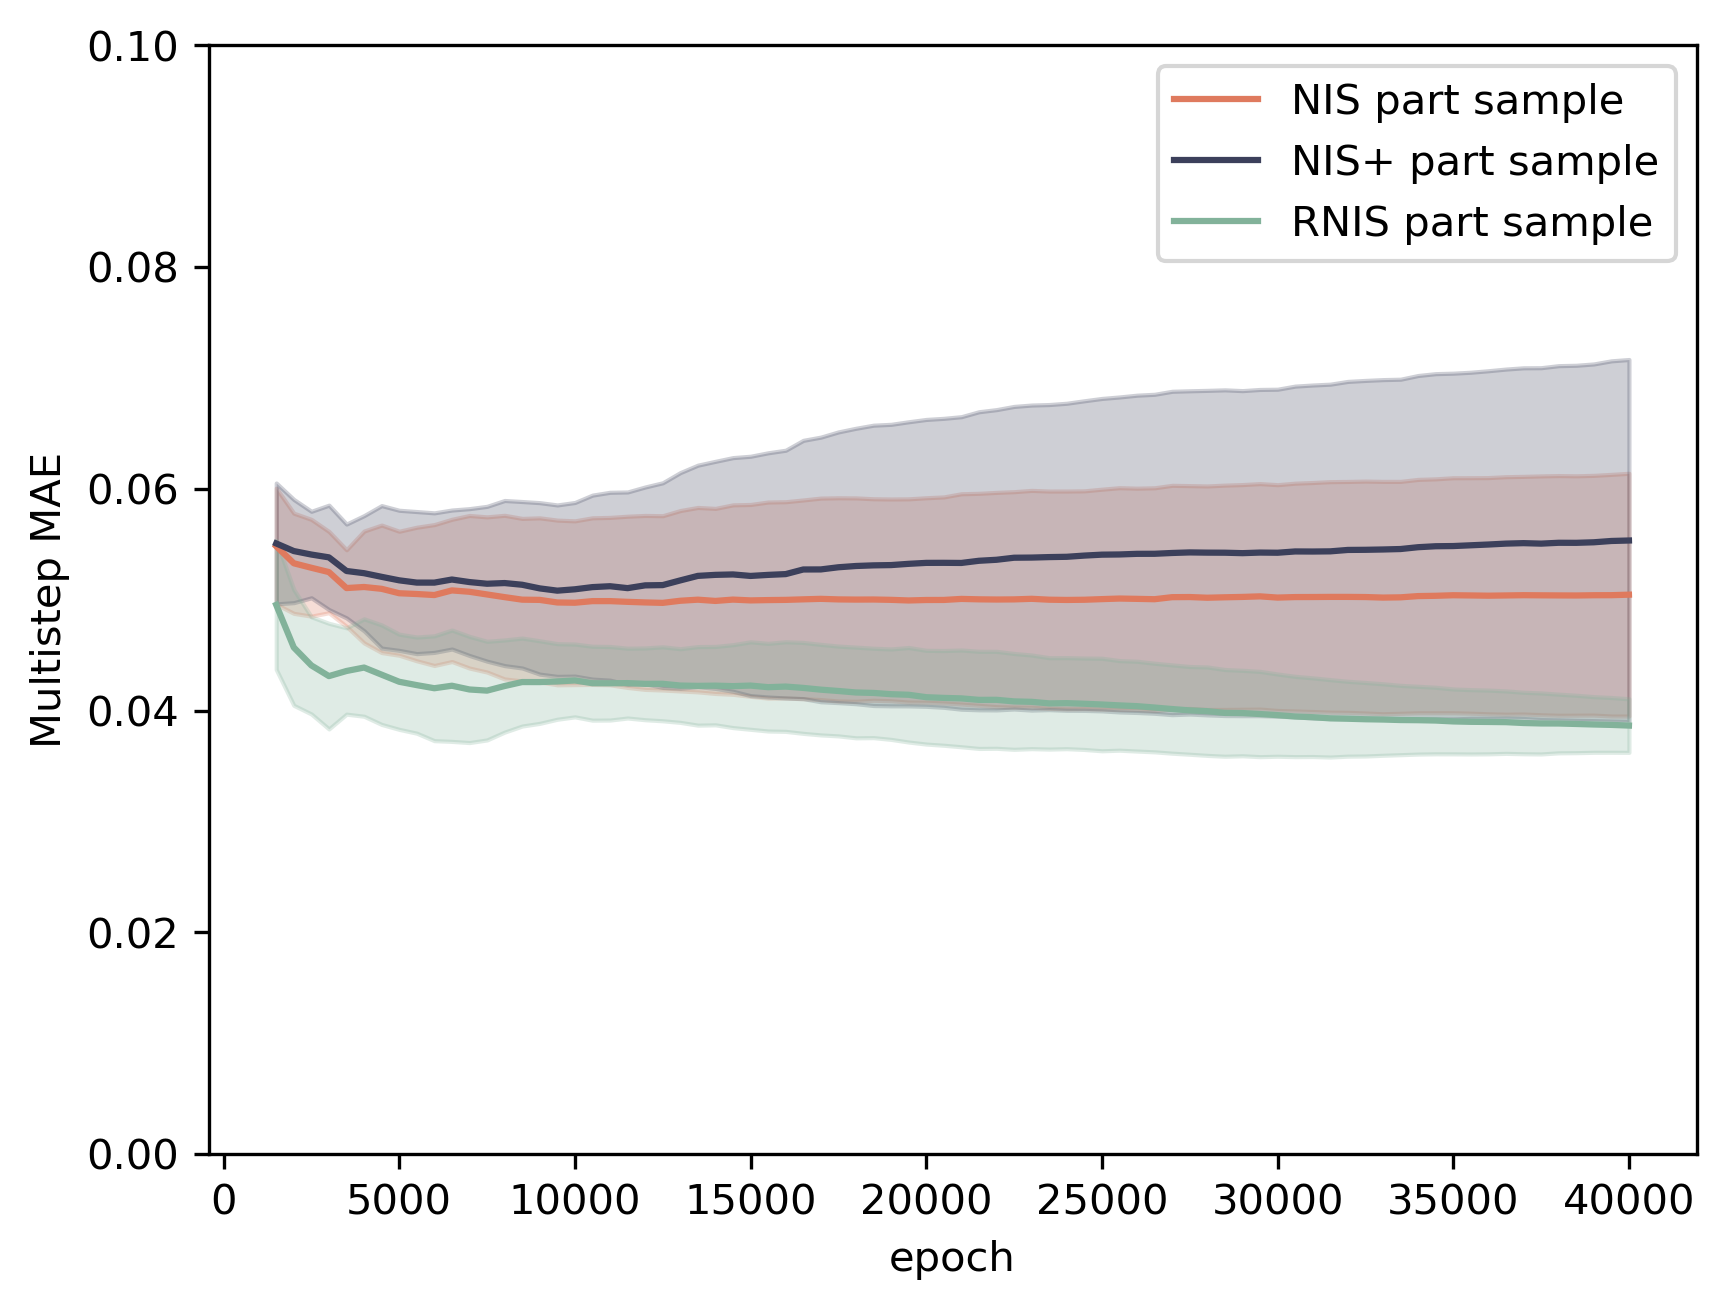

In [13]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
lens=len(MAEs_mstep_nis_e[0,3:])
timesteps = np.arange(len(MAEs_mstep_nis_e[0,:]))[3:]*500
compare1=np.cumsum(data_dict['MAEs_mstep_nis_e'][:,3:],1)/np.linspace(1, lens, lens)
compare2=np.cumsum(data_dict['MAEs_mstep_nisp_e'][:,3:],1)/np.linspace(1, lens, lens)
compare3=np.cumsum(data_dict['MAEs_mstep_rnis_e'][:,3:],1)/np.linspace(1, lens, lens)
means_nis = np.mean(compare1,axis=0)
stds_nis = np.std(compare1,axis=0)
means_nisp = np.mean(compare2,axis=0)
stds_nisp = np.std(compare2,axis=0)
means_rnis = np.mean(compare3,axis=0)
stds_rnis = np.std(compare3,axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.plot(timesteps, means_rnis, label='RNIS part sample',color=color_label[3])
plt.fill_between(timesteps, means_rnis-stds_rnis, means_rnis+stds_rnis,alpha=0.25,color=color_label[3])
plt.legend()
plt.xlabel("epoch")
plt.ylabel('Multistep MAE')
plt.ylim([0,0.1])
plt.show()

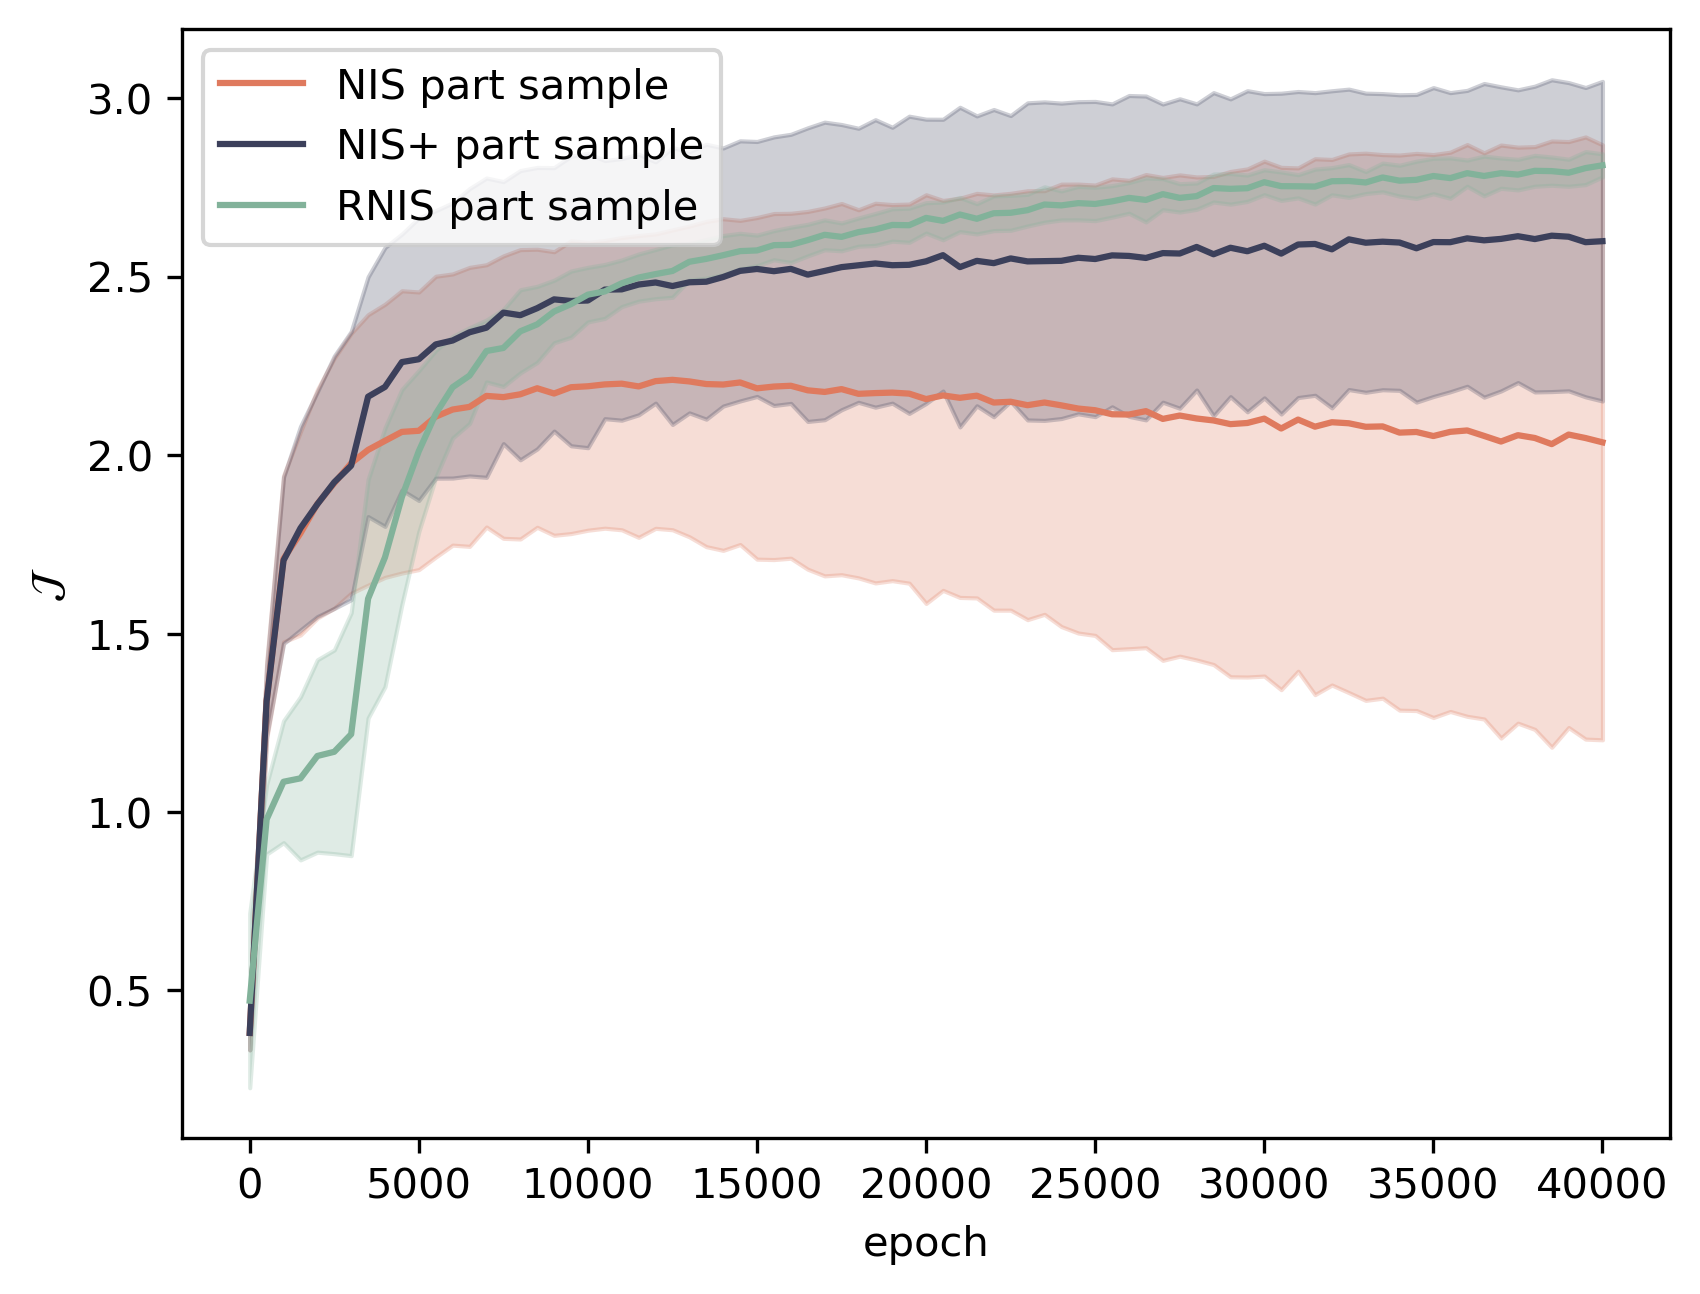

In [14]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
timesteps = np.arange(len(eis_nis))*500
means_nis = np.mean(data_dict['eis_nis_e'],axis=0)
stds_nis = np.std(data_dict['eis_nis_e'],axis=0)
means_nisp = np.mean(data_dict['eis_nisp_e'],axis=0)
stds_nisp = np.std(data_dict['eis_nisp_e'],axis=0)
means_rnis = np.mean(data_dict['eis_rnis_e'],axis=0)
stds_rnis = np.std(data_dict['eis_rnis_e'],axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.plot(timesteps, means_rnis, label='RNIS part sample',color=color_label[3])
plt.fill_between(timesteps, means_rnis-stds_rnis, means_rnis+stds_rnis,alpha=0.25,color=color_label[3])
plt.legend()
plt.xlabel("epoch")
plt.ylabel(r'$\mathcal{J}$')
plt.show()

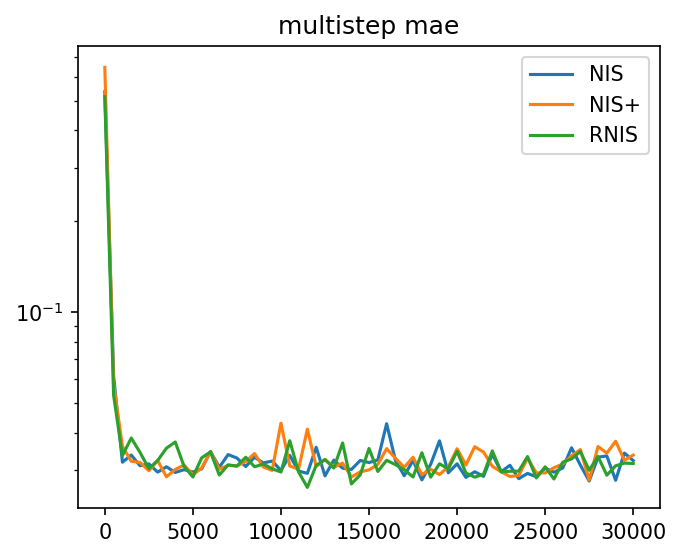

In [16]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis))*500
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'multistep mae')
plt.legend()
plt.yscale('log')
plt.show()

In [7]:
for name, param in net_rnis.flow.named_parameters():
    print(name, param.data)

mask tensor([[0., 0., 1., 1.],
        [1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [1., 1., 0., 0.]], device='cuda:0')
t.0.0.weight tensor([[-0.4500,  0.2481, -0.3307, -0.3997],
        [-0.3159,  0.0245,  0.3016,  0.4140],
        [ 0.1007,  0.1977,  0.0567, -0.4584],
        [-0.4355, -0.0784, -0.0569,  0.0530],
        [ 0.4552, -0.0023,  0.4468,  0.0159],
        [-0.4983,  0.3343,  0.3172,  0.4217],
        [-0.0352, -0.0224,  0.2749, -0.1239],
        [-0.0317,  0.4741,  0.1126,  0.0538],
        [ 0.3216, -0.0651,  0.2776,  0.2967],
        [ 0.1679, -0.3393, -0.0970, -0.3154],
        [ 0.0962,  0.3104, -0.0246, -0.4958],
        [ 0.4517,  0.2366,  0.3457,  0.0936],
        [ 0.2456, -0.3513,  0.1983,  0.4215],
        [-0.2745,  0.4596,  0.0136, -0.1396],
        [-0.0013, -0.3562,  0.1834,  0.2691],
        [-0.4839,  0.1174, -0.0864, -0.3621],
        [-0.3382,  0.3901,  0.0997, -0.4168],
        [ 0.4794, -0.1877,